## 心得：
1. 房地產資料不取log，使用xgboost算出rmse為：
    + train-rmse:1.30887e+07	valid-rmse:1.4942e+07


2. 一千四百萬元的rmse感覺很誇張，畫出PCA圖發現有2~3個離群值
3. 另外嘗試使用sklearn的各種演算法，鐵達尼號的分類演算法都不能用，因為預測房價屬於regression的範疇。
4. 嘗試使用sklearn的GradientBoostingRegressor，valis-rmse為1.8751e+07較差，PCA圖和xgboost十分相似，一樣看到2~3個離群值
5. 並非只要是regression的演算法就能使用，測試sklearn的Support Vector Regression，解出來的房價是一個常數(一千八百萬)，decision forest
   regression rmse更糟(2593萬元)
6. 不同演算法的feature不同，XGboost重視面積、附近房價，GradientBoostingRegressor卻重視面積平方、地段
   

In [95]:
import pandas as pd
import os
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.linear_model import LogisticRegressionCV  ## logistic regression
from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.svm import SVC, SVR  ## SVM

from sklearn.tree import DecisionTreeClassifier  ## decision tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import xgboost

In [2]:
if 'df_realestate.csv' not in os.listdir('data'):
    url = 'https://s3.amazonaws.com/datasets-jeremy/df_realestate.csv'  
    urllib.request.urlretrieve(url, os.path.join('data', 'df_realestate.csv')) 
    
if 'df_realestate_processed.csv' not in os.listdir('data'):
    url = 'https://s3.amazonaws.com/datasets-jeremy/df_realestate_processed.csv'  
    urllib.request.urlretrieve(url, os.path.join('data', 'df_realestate_processed.csv'))  

In [40]:
# before preprocessing
file = os.path.join('data', 'df_realestate.csv')
df_realestate = pd.read_csv(file, encoding='big5')
df_realestate

# processed
path = "data//df_realestate_processed.csv"
df_realestate_processed = pd.read_csv(path)
df_realestate_processed.dropna(inplace=True)  #有兩列資料中有NA值，drop掉
X = df_realestate_processed.drop(["price_per_meter", "total_price"], axis=1)
Y = df_realestate_processed['total_price']


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (5,6,8,11,13,21,29,32,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [144]:
print( X.info() )
print( X[['area', 'nearest_point_avg_price', 'house_year', 'cross_RC_area', 'cross_resirential_area', 'income_avg']].describe() ) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52948 entries, 0 to 52949
Columns: 252 entries, area to cross_business_factory
dtypes: float64(98), int64(154)
memory usage: 102.2 MB
None
               area  nearest_point_avg_price    house_year  cross_RC_area  \
count  52948.000000             5.294800e+04  52948.000000   52948.000000   
mean     152.126043             1.915195e+05     21.946415     131.809803   
std      531.819491             1.320697e+05     14.603055     341.091471   
min        1.100000             1.890000e+03      0.000000       0.000000   
25%       70.437500             1.434169e+05      8.000000      55.710000   
50%      106.590000             1.792706e+05     22.000000     100.780000   
75%      165.930000             2.222772e+05     35.000000     156.520000   
max    69125.530000             7.959706e+06    103.000000   27676.220000   

       cross_resirential_area    income_avg  
count            52948.000000  52948.000000  
mean                61.67

In [130]:
# lab_enc = preprocessing.LabelEncoder()

X_train = X.iloc[:-1000]
Y_train = Y.iloc[:-1000]
# Y_train = np.log(Y_train) 依作業要求不取log
Y_train_drop_head_tail = Y_train.sort_values()[1:-2]
X_train_drop_head_tail = X_train.loc[Y_train_drop_head_tail.index, :]  # 去掉四個極端房價

X_valid = X.iloc[-1000:]
Y_valid = Y.iloc[-1000:]
# Y_valid = np.log(Y_valid) 依作業要求不取log

In [82]:
# Set our parameters for xgboost
params = {}

# 請填入以下參數: 
# 目標函數: 線性回歸
# 評價函數: rmse
# 學習速度: 0.01
# 最大深度: 5
# bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=50, verbose_eval=10)
#=============your works starts===============#
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.03
params['max_depth'] = 3
d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=10, verbose_eval=10)
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
#==============your works ends================#

[14:08:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:1.46463e+08	valid-rmse:4.06844e+07
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[14:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:08:22] C:\Users\Administrator\Desktop\xgboost\

In [133]:
# 算出去掉總價頭尾的rmse

d_train = xgboost.DMatrix(X_train_drop_head_tail, label=Y_train_drop_head_tail)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=10, verbose_eval=10)
Y_pred_drop = bst.predict(xgboost.DMatrix(X_valid))

[15:36:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:8.38412e+07	valid-rmse:4.07008e+07
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[15:36:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:36:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:36:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:36:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:36:51] C:\Users\Administrator\Desktop\xgboost\

## 用sklearn的GradientBoostingRegressor試試

MSE: 353731257097356.8125


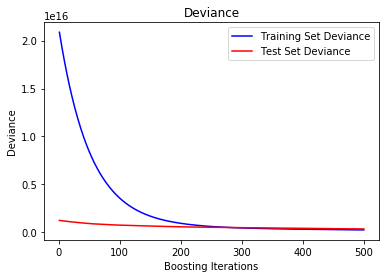

In [78]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, Y_train)
mse = mean_squared_error(Y_valid, clf.predict(X_valid))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_valid)):
    test_score[i] = clf.loss_(Y_valid, y_pred)


plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.title('Deviance')
plt.show()


In [27]:
# rmse
rmse = mse ** 0.5
rmse
# 1.8751e+07 不如xgboost 1.4942e+07

18751693.43815722

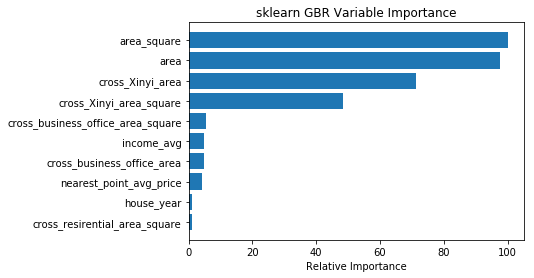

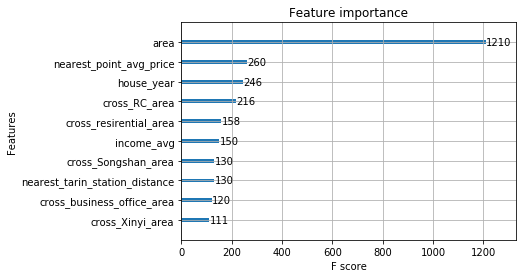

In [79]:
# Plot feature importance

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)   #讓重要度由大到小排列
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos[-10:], feature_importance[sorted_idx[-10:]], align='center')
plt.yticks(pos[-10:], X.columns[sorted_idx[-10:]])
plt.xlabel('Relative Importance')
plt.title('sklearn GBR Variable Importance')

# 請使用 xgboost.plot_importance，並設定max_num_features=10
#!=============your works starts===============!#
xgboost.plot_importance(bst, max_num_features=10)
#!==============your works ends================!#

plt.show()



In [21]:
sorted_idx[:10]

array([-251, -137, -138, -139, -141, -143, -145, -146, -147, -148],
      dtype=int64)

In [42]:
X.columns[:10]

Index(['area', 'house_year', 'have_manager', 'current_division',
       'have_added_building', 'is_for_household', 'us_for_business',
       'is_resirential_building', 'is_Huaxia', 'is_apartment'],
      dtype='object')

In [43]:
X.columns[sorted_idx[-10:]]

Index(['house_year', 'cross_resirential_area', 'nearest_point_avg_price',
       'income_avg', 'cross_business_office_area_square',
       'cross_business_office_area', 'cross_Xinyi_area',
       'cross_Xinyi_area_square', 'area', 'area_square'],
      dtype='object')

## 畫出PCA圖

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


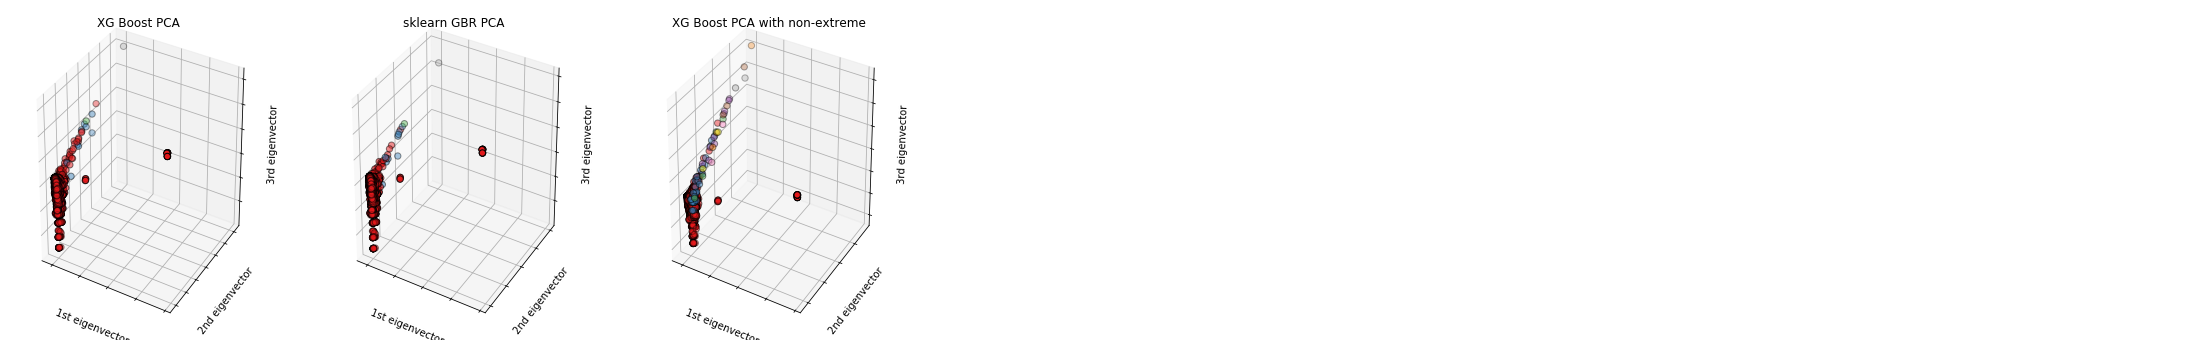

In [137]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# xgboost PCA

XX = df_realestate_processed[['area', 'nearest_point_avg_price', 'house_year', 'cross_RC_area', 'cross_resirential_area', 'income_avg']].values
YY = np.array(df_realestate_processed.total_price)

#!=============your works starts===============!#

fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(1, 3, 1, projection='3d')
X_reduced = PCA(n_components=3).fit_transform(XX)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=YY,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("XG Boost PCA")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
#!==============your works ends================!#
# sklearn GBR PCA
plt.subplot(1, 3, 2)
XX = df_realestate_processed[['area','cross_Xinyi_area','cross_business_office_area','income_avg','nearest_point_avg_price','cross_resirential_area']].values
YY = np.array(df_realestate_processed.total_price)

#!=============your works starts===============!#
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(1, 3, 2, projection='3d')

X_reduced = PCA(n_components=3).fit_transform(XX)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=YY,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("sklearn GBR PCA")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

# 資料去掉最大、最小兩個房價後的xgboost PCA圖
ax = fig.add_subplot(1, 3, 3, projection='3d')
X_reduced = PCA(n_components=3).fit_transform(X_train_drop_head_tail[['area', 'nearest_point_avg_price', 'house_year', 'cross_RC_area', 'cross_resirential_area', 'income_avg']].values)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=np.array(Y_train_drop_head_tail),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("XG Boost PCA with non-extreme")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

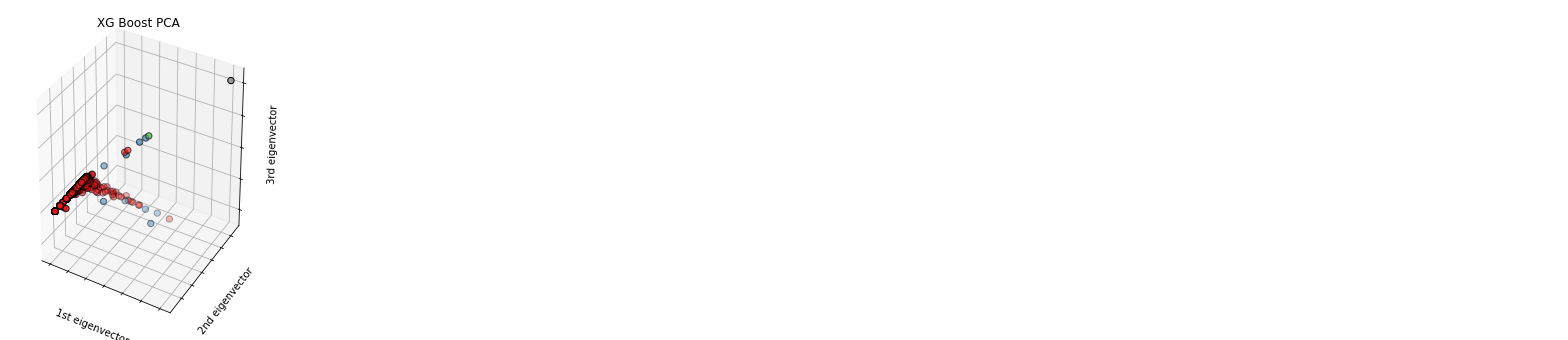

In [147]:
df_realestate_processed['log_nearest_point_avg_price'] = np.log10(df_realestate_processed.nearest_point_avg_price)

XX = df_realestate_processed[['area', 'log_nearest_point_avg_price', 'house_year', 'cross_RC_area', 'cross_resirential_area', 'income_avg']].values
YY = np.array(df_realestate_processed.total_price)

#!=============your works starts===============!#
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(1, 3, 1, projection='3d')
X_reduced = PCA(n_components=3).fit_transform(XX)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=YY,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("XG Boost PCA")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [148]:
# 把nearest_point_avg_price取log

X = df_realestate_processed.drop(["price_per_meter", "total_price", "nearest_point_avg_price"], axis=1)
Y = df_realestate_processed['total_price']

X_train = X.iloc[:-1000]
Y_train = Y.iloc[:-1000]
# Y_train = np.log(Y_train) 依作業要求不取log

X_valid = X.iloc[-1000:]
Y_valid = Y.iloc[-1000:]

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgboost.train(params, d_train, 3000, watchlist, early_stopping_rounds=10, verbose_eval=10)
Y_pred_drop = bst.predict(xgboost.DMatrix(X_valid))

[16:19:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-rmse:1.46463e+08	valid-rmse:4.06844e+07
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[16:19:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[16:19:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[16:19:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[16:19:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[16:19:28] C:\Users\Administrator\Desktop\xgboost\

In [151]:
df_realestate_processed.log_nearest_point_avg_price

0        5.126094
1        5.249546
2        5.387592
3        5.092427
4        5.042754
5        5.110258
6        5.499927
7        5.182790
8        5.401318
9        5.319768
10       5.253783
11       5.219651
12       5.395346
13       5.196105
14       5.314697
15       5.473233
16       5.354760
17       5.195652
18       5.345480
19       5.370340
20       5.358510
21       5.504909
22       5.399637
23       5.380895
24       5.206384
25       5.464192
26       5.284249
27       5.097315
28       5.407840
29       5.205429
           ...   
52920    5.265247
52921    5.460446
52922    5.219825
52923    5.064853
52924    5.228594
52925    5.405689
52926    5.289912
52927    5.119554
52928    5.125110
52929    5.142378
52930    5.171448
52931    5.018564
52932    5.251488
52933    5.052131
52934    5.483874
52935    5.339990
52936    5.359542
52937    5.172064
52938    5.243506
52939    5.111412
52940    5.296627
52941    5.219990
52942    5.276325
52943    5.140171
52944    5

## 用sklearn的SVM regression演算法試試

In [83]:
from sklearn import svm

clf = svm.SVR()
clf.fit(X_train, Y_train) 

clf.predict(X_valid)


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333333, 18000035.67333333,
       18000035.67333333, 18000035.67333

## 用sklearn的decision tree regression演算法試試

In [84]:
from sklearn.tree import DecisionTreeRegressor


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, Y_train)
regr_2.fit(X_train, Y_train)

# Predict
y_1 = regr_1.predict(X_valid)
y_2 = regr_2.predict(X_valid)



In [92]:
regr_3 = DecisionTreeRegressor(max_depth=100)
regr_3.fit(X_train, Y_train)

y_3 = regr_3.predict(X_valid)

In [85]:
y_1

array([29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573, 29000982.3779573, 29000982.3779573,
       29000982.3779573,

In [86]:
y_2

array([1.28084238e+07, 2.59846686e+07, 2.59846686e+07, 1.28084238e+07,
       1.28084238e+07, 1.28084238e+07, 2.59846686e+07, 2.59846686e+07,
       1.28084238e+07, 1.28084238e+07, 1.28084238e+07, 1.28084238e+07,
       1.28084238e+07, 1.28084238e+07, 1.28084238e+07, 1.28084238e+07,
       1.28084238e+07, 1.28084238e+07, 1.28084238e+07, 2.59846686e+07,
       1.28084238e+07, 1.28084238e+07, 1.28084238e+07, 7.59429614e+07,
       1.28084238e+07, 2.59846686e+07, 2.59846686e+07, 1.28084238e+07,
       1.28084238e+07, 2.59846686e+07, 1.28084238e+07, 1.28084238e+07,
       1.28084238e+07, 1.28084238e+07, 1.28084238e+07, 2.59846686e+07,
       1.28084238e+07, 1.28084238e+07, 1.28084238e+07, 2.59846686e+07,
       1.28084238e+07, 2.59846686e+07, 2.59846686e+07, 1.28084238e+07,
       1.28084238e+07, 1.28084238e+07, 1.28084238e+07, 1.28084238e+07,
       1.28084238e+07, 1.28084238e+07, 1.28084238e+07, 1.28084238e+07,
       1.28084238e+07, 1.28084238e+07, 2.59846686e+07, 1.28084238e+07,
      

In [93]:
y_3

array([1.37000284e+07, 8.10005670e+06, 3.00000477e+07, 3.36600087e+07,
       2.70000498e+06, 1.69999830e+07, 1.11000090e+07, 3.71999285e+07,
       8.25001375e+06, 7.19999280e+06, 8.80001056e+06, 2.76595143e+07,
       1.00000207e+07, 1.80000270e+07, 3.00000331e+07, 1.33800373e+07,
       1.30600399e+07, 1.84999651e+07, 1.79000350e+07, 1.57199518e+07,
       1.35000294e+06, 1.70000239e+07, 7.19999280e+06, 2.89340095e+08,
       6.49997608e+06, 9.00003720e+06, 4.11799826e+07, 9.49997652e+06,
       6.10000480e+06, 1.41000370e+07, 1.02500017e+07, 9.60003576e+06,
       6.80164596e+06, 1.82000138e+07, 1.65000352e+07, 1.95000535e+07,
       1.99998500e+05, 1.29999622e+07, 1.39999749e+07, 1.95999693e+07,
       2.69999823e+07, 3.18799900e+07, 3.08000251e+07, 3.80000356e+07,
       1.69999507e+07, 8.59999272e+06, 1.08000098e+07, 7.99999368e+06,
       7.99999368e+06, 7.99999368e+06, 1.22499993e+07, 1.46999610e+07,
       1.10000232e+07, 1.47999918e+07, 2.62800298e+07, 1.84999957e+07,
      

In [88]:
decisiontree_rmse = ((Y_valid - y_2) ** 2).mean() ** .5
decisiontree_rmse

25932378.82743646

In [94]:
decisiontree_rmse = ((Y_valid - y_3) ** 2).mean() ** .5
decisiontree_rmse

27452253.86990691